# Diffusion-decay ingrowth model

This script shows how to set up a diffusion-decay-ingrowth model in UWDiffusion in a zircon mesh geometry. It shows how to update the diffusivity of the parent and daughter isotopes during the model run if the temperature changes.


------

First we import the required modules

In [1]:
import os
import time

In [2]:
os.environ["UW_TIMING_ENABLE"] = "1"
from underworld3 import timing

In [3]:
import underworld3 as uw
import UWDiffusion as DIF

import h5py

In [4]:
import numpy as np
import sympy as sp
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

------
We include the timing in this script to see how the model performs

In [5]:
timing.reset()
timing.start()
time_start = time.time()

------
Here we setup some parameters for the model for the unknown and discretisation of the domain.

These can either be modified in the script or specified in the command line, e.g. 
`python3 zircon-U-Pb-example.py -uw_csize 0.01` 
to modify the cell cize to 0.01

In [6]:
U_degree    = uw.options.getInt("U_degree", default=2)
continuous  = uw.options.getBool("continuous", default=True)

csize       = uw.options.getReal("csize", default=0.02)

tolerance   = uw.options.getReal("tolerance", default=1e-6)


save_figs    = uw.options.getBool("save_figs", default=True)

CFL_fac      = uw.options.getReal("CFL_fac", default=0.5)


if uw.mpi.rank == 0:
    print(f'csize = {csize}, CFL = {CFL_fac}, degree = {U_degree},')

csize = 0.02, CFL = 0.5, degree = 2,


------
Below, we setup some parameters of the model to test against the benchmark. Modifying these parameters will automatically update the analytical solution.

In [7]:
T_start = uw.options.getReal("Temp_start", default=800) ### C
T_end   = uw.options.getReal("Temp_end", default=800) ### C
t_start = uw.options.getReal("time_start", default=0) ### Myr
t_end   = uw.options.getReal("time_end", default=500) ### Myr,

if uw.mpi.rank == 0:
    print(f'T_start = {T_start}, T_end = {T_end}, t_start = {t_start}, t_end = {t_end}')

duration = (t_end - t_start)

gradient = (T_start - T_end) / ( t_end - t_start)

if gradient == 0:
    outputPath  = uw.options.getString('outputPath', default=f'./output/Diffusion-Decay-ingrowth-T={T_start}C-t={t_end}Myr-degree={U_degree}-csize={csize}-CFL={CFL_fac}/')
else:
    outputPath  = uw.options.getString('outputPath', default=f'./output/Diffusion-Decay-ingrowth={T_start}C-gradient={gradient}CMyr-t={t_end}Myr-degree={U_degree}-csize={csize}-CFL={CFL_fac}/')

if uw.mpi.rank == 0:
    os.makedirs(outputPath, exist_ok=True)




T_start = 800.0, T_end = 800.0, t_start = 0.0, t_end = 500.0


In [8]:
time_profile = np.linspace(t_start, t_end, int(t_end) ) ### every 1 Myr
temp_profile = np.linspace(T_start, T_end, int(t_end) ) ### corresponding temp

# Create the interpolator, which allows the current temperature to be determined at the current time (in Myr)
temperature_interp = interp1d(
    time_profile, 
    temp_profile,
    kind='linear', 
    fill_value='extrapolate' 
)



#### The diffusion coefficient (D)
------
Here we outline the variables to determine the diffusion coefficient for U and Pb. We use sympy to generate a symbolic equation and substitute the values in.

------


Table of variables to determine the diffusion coefficient for each element
| Variable | Symbol            | units | U | Pb | 
| :---------- | :-------: | :-------: | :------: |  ------: | 
| Pre-exponent| $D_0$   | $\text{m}^2\, \text{s}^{-1}$ |  1.63   | 0.11 |
| Activation energy | $E_a$  | $\text{kJ}\, \text{mol}^{-1}$ |  726 $\pm$ 83    |  550 $\pm$ 30  |
| Gas constant | $R$  | $\text{J}\, \text{mol}^{-1}\, \text{K}^{-1}$ |  8.314    | 8.314 | 
| Reference | |  | [Cherniak and Watson, 1997](http://link.springer.com/10.1007/s004100050287) | [Cherniak and Watson, 2001](https://www.sciencedirect.com/science/article/pii/S0009254100002333) | [Cherniak and Watson, 2007](https://www.sciencedirect.com/science/article/pii/S0009254107002148) | 

##### we make the symbolic form into equations for both U and Pb by substituting in the required values

In [9]:
D, E, R, T = sp.symbols('D E R T') # Temperature in Kelvin

D_sym = D * sp.exp(-E / (R * (T+ 273.15) ) )

In [10]:
def diffusivity_fn(D_sym, D0, Ea):
    D_exp = D_sym.subs({D: D0, E: Ea, R: 8.314}).simplify()
    return sp.lambdify(T, D_exp, 'numpy')

D_Pb_fn = diffusivity_fn(D_sym, D0=0.11, Ea=550e3)
D_U_fn = diffusivity_fn(D_sym, D0=10**0.212, Ea=726e3)

#### Here we calculate the initial U-238 and U-235 amounts at the model start time based on their current abudance

This could be modified for any parent-daughter isotope system

In [ ]:
import sympy as sp

# Symbolic variable for elapsed time (years)
t = sp.Symbol('t')

# Constants: half-lives in years
half_life_U235 = 703.8e6
half_life_U238 = 4.468e9

# Decay constants (yr^-1)
lambda_U235 = sp.log(2) / half_life_U235
lambda_U238 = sp.log(2) / half_life_U238

# Present-day U-238/U-235 ratio (dimensionless)
current_ratio_U238_to_U235 = 137.818

# Abundance at time t (years ago), normalized so present-day U-235 = 1
U235_fn = sp.Lambda(t, sp.exp(lambda_U235 * t))
U238_fn = sp.Lambda(t, current_ratio_U238_to_U235 * sp.exp(lambda_U238 * t))
ratio_fn = sp.Lambda(t, U238_fn(t) / U235_fn(t))

U235_amount = float(U235_fn(t_end * 1e6))
U238_amount = float(U238_fn(t_end * 1e6))
U238_U235_ratio = float(ratio_fn(t_end * 1e6))

if uw.mpi.rank == 0:
    print(f"U-235 abundance at {t_end:.2e} Ma (normalized): {U235_amount:.4f}")
    print(f"U-238 abundance at {t_end:.2e} Ma (normalized): {U238_amount:.4f}")
    print(f"U-238/U-235 ratio at {t_end:.2e} Ma: {U238_U235_ratio:.2f}")

U-235 abundance at 5.00e+08 yr ago (normalized): 1.6363
U-238 abundance at 5.00e+08 yr ago (normalized): 148.9338
U-238/U-235 ratio at 5.00e+08 yr ago: 91.02


#### Scaling the model
------
Numerical models are easier to solve when non-dimensionalised. Here we use pint to set some scaling coefficients that can be used to non-dimensionalise values used in the model.

In [12]:
# import unit registry
u = uw.scaling.units

### make scaling easier
ndim, nd = uw.scaling.non_dimensionalise, uw.scaling.non_dimensionalise
dim  = uw.scaling.dimensionalise 


diffusive_rate    = D_Pb_fn(T_start) * u.meter**2 /u.second
model_length      = 100 * u.micrometer ### scale the mesh radius to the zircon radius


KL = model_length
Kt = model_length**2 / diffusive_rate


scaling_coefficients  = uw.scaling.get_coefficients()
scaling_coefficients["[length]"] = KL
scaling_coefficients["[time]"] = Kt

scaling_coefficients

[mass],1.0 kilogram
[length],9.999999999999999e-05 meter
[temperature],1.0 kelvin
[time],5.37457791566322e+19 second
[substance],1.0 mole


#### Here we define the mesh geometry to create a zircon-shaped 2D mesh.
We provide the points of which the mesh is constructed

In [13]:
### width (x) = 0.6 (60 micron), height (y) = 1. (100 micron)

points = [(-0.3, 0.35, 0), (-0.2, 0.5, 0), (0.2, 0.5, 0), (0.3, 0.35, 0), 
          (0.3, -0.35, 0), (0.2, -0.5, 0), (-0.2, -0.5, 0), (-0.3,-0.35, 0)]

points_array = np.array(points)

In [14]:
zircon_mesh = DIF.meshing.generate_2D_mesh_from_points(points_array, csize, U_degree)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.000279666s, CPU 0.000399s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0267545s, CPU 0.026317s)
Info    : 1790 nodes 3586 elements
Info    : Writing './.meshes/point_mesh_2D_csize=0.02_degree=2.msh'...
Info    : Done writing './.meshes/point_mesh_2D_csize=0.02_degree=2.msh'


------
Here, the diffusion-decay-ingrowth model is set up. The parent and daughter isotope names are provided, along with the parent isotope half life and initial amount. 

-----

In [15]:
U238_Pb206 = DIF.DiffusionDecayIngrowthModel (
        parent_name=r"{}^{238}\text{U}", daughter_name=r"{}^{206}\text{Pb}", half_life=half_life_U238*u.year, mesh=zircon_mesh
    )

U235_Pb207 = DIF.DiffusionDecayIngrowthModel (
        parent_name=r"{}^{235}\text{U}", daughter_name=r"{}^{207}\text{Pb}", half_life=half_life_U235*u.year, mesh=zircon_mesh
    )

In [16]:
with U238_Pb206.mesh.access(U238_Pb206.parent_mesh_var, U238_Pb206.daughter_mesh_var):
    U238_Pb206.parent_mesh_var.data[:, 0] = U238_amount
    U238_Pb206.daughter_mesh_var.data[:, 0] = 0.0

U238_Pb206.init_model()

In [17]:
with U235_Pb207.mesh.access(U235_Pb207.parent_mesh_var, U235_Pb207.daughter_mesh_var):
    U235_Pb207.parent_mesh_var.data[:, 0] = U235_amount
    U235_Pb207.daughter_mesh_var.data[:, 0] = 0.0

U235_Pb207.init_model()

------
The diffusivity of both the parent and daughter isotopes need  to be set for each model. This is done through either the _*.parent_diffusivity_ or _*.daughter_diffusivity_ parameters.


-----

In [18]:
T_initial = temperature_interp(0) ### temperature at time 0

Pb_kappa = (D_Pb_fn(T_initial) * u.meter**2 / u.second)
U_kappa = (D_U_fn(T_initial) * u.meter**2 / u.second)

In [19]:
U238_Pb206.parent_diffusivity = D_U_fn(T_initial) * u.meter**2 / u.second

U238_Pb206.daughter_diffusivity = D_Pb_fn(T_initial) * u.meter**2 / u.second

In [20]:
U235_Pb207.parent_diffusivity = D_U_fn(T_initial) * u.meter**2 / u.second

U235_Pb207.daughter_diffusivity = D_Pb_fn(T_initial) * u.meter**2 / u.second

##### Here we set the boundary condition at the edge of the mesh, with 0 concentration used in this example for both the parent and daughter isotopes.

In [21]:
value = sp.Float(0)

for _solver in [U235_Pb207.parent_diffusion, U235_Pb207.daughter_diffusion, U238_Pb206.parent_diffusion, U238_Pb206.daughter_diffusion]:
    for _boundary in _solver.mesh.boundaries:
        if hasattr(_boundary, "name") and _boundary.name.startswith("Boundary"):
            _solver.add_dirichlet_bc([value], _boundary.name)     

    _solver.petsc_options["snes_rtol"]   = tolerance*1e-4
    _solver.petsc_options["snes_atol"]   = tolerance
    _solver.petsc_options["ksp_atol"]    = tolerance
    _solver.petsc_options["snes_max_it"] = 100
    _solver.petsc_options["snes_monitor_short"] = None 

------
We setup a function to update the diffusivity (kappa) as the model is running. This is to capture changes in diffusivity _if_ the temperature changes

-----

In [22]:
def update_kappa(Model, D_p_fn, D_d_fn, temperature_interp):
    current_temp = temperature_interp(dim(Model.current_time, u.megayear).m) #T_start - gradient*dim(Model.current_time, u.megayear).m
    kappa_p = D_p_fn(current_temp)
    kappa_d = D_d_fn(current_temp)
    Model.parent_diffusivity = kappa_p * u.meter**2 / u.second
    Model.daughter_diffusivity = kappa_d * u.meter**2 / u.second



In [23]:
def update_kappa_wrapper():
    update_kappa(U238_Pb206, D_U_fn, D_Pb_fn, temperature_interp)


U238_Pb206.register_pre_solve_hook('update kappa routine', update_kappa_wrapper)

------
Due to the diffusivity changing, we need to constrain how large we'd like timesteps to be.

Here we set a maximum allowed $\Delta$T to determine the largest timestep permitted (max_dt).

We can also set a minimum timestep (min_dt), as the timesteps will become expoentially small as temperature increases

-----

In [24]:
dTdt = np.diff(temp_profile) / np.diff(time_profile)
max_allowed_temp_change = 5 ### C
dt_temp_change = np.min(max_allowed_temp_change / np.maximum(np.abs(dTdt), 1e-12))

In [25]:
U238_Pb206.run_simulation(duration=t_end*u.megayear, min_dt=0.1*u.megayear, max_dt=dt_temp_change*u.megayear, diffusion_time_step_factor=CFL_fac)


Step 0, dt: 45.87700263306446 Myr,  Time: 0.00 Myr
  0 SNES Function norm 310.539
  1 SNES Function norm 0.0120923
  2 SNES Function norm 6.03219e-06
  0 SNES Function norm 43477.3
  1 SNES Function norm 0.470663
  2 SNES Function norm 3.53297e-06

Step 1, dt: 45.87700263306446 Myr,  Time: 45.88 Myr
  0 SNES Function norm 614.053
  1 SNES Function norm 0.0233379
  2 SNES Function norm 2.03996e-06
  0 SNES Function norm 43168.9
  1 SNES Function norm 0.467325
  2 SNES Function norm 3.50791e-06

Step 2, dt: 45.87700263306446 Myr,  Time: 91.75 Myr
  0 SNES Function norm 912.622
  1 SNES Function norm 0.0344772
  2 SNES Function norm 2.88728e-06
  0 SNES Function norm 42862.8
  1 SNES Function norm 0.464011
  2 SNES Function norm 3.48303e-06

Step 3, dt: 45.87700263306446 Myr,  Time: 137.63 Myr
  0 SNES Function norm 1207.
  1 SNES Function norm 0.0456353
  2 SNES Function norm 3.75925e-06
  0 SNES Function norm 42558.8
  1 SNES Function norm 0.46072
  2 SNES Function norm 3.45833e-06

St

In [26]:
def update_kappa_wrapper():
    update_kappa(U235_Pb207, D_U_fn, D_Pb_fn, temperature_interp)


U235_Pb207.register_pre_solve_hook('update kappa routine', update_kappa_wrapper)

In [27]:
U235_Pb207.run_simulation(duration=t_end*u.megayear, min_dt=0.1*u.megayear, max_dt=dt_temp_change*u.megayear, diffusion_time_step_factor=CFL_fac)


Step 0, dt: 45.87700263306446 Myr,  Time: 0.00 Myr
  0 SNES Function norm 21.2528
  1 SNES Function norm 0.00082758
  2 SNES Function norm 6.34862e-06
  0 SNES Function norm 459.83
  1 SNES Function norm 0.00497789
  2 SNES Function norm 2.50521e-06

Step 1, dt: 45.87700263306446 Myr,  Time: 45.88 Myr
  0 SNES Function norm 41.2372
  1 SNES Function norm 0.00156676
  2 SNES Function norm 3.87152e-06
  0 SNES Function norm 439.516
  1 SNES Function norm 0.00475799
  2 SNES Function norm 2.39454e-06

Step 2, dt: 45.87700263306446 Myr,  Time: 91.75 Myr
  0 SNES Function norm 60.1482
  1 SNES Function norm 0.00227189
  2 SNES Function norm 5.32919e-06
  0 SNES Function norm 420.1
  1 SNES Function norm 0.00454779
  2 SNES Function norm 2.28875e-06

Step 3, dt: 45.87700263306446 Myr,  Time: 137.63 Myr
  0 SNES Function norm 78.0825
  1 SNES Function norm 0.00295245
  2 SNES Function norm 2.57384e-06
  0 SNES Function norm 401.541
  1 SNES Function norm 0.00434688
  2 SNES Function norm 2.1

#### Here we extract the required ratios for the Terra-Wasserburg plot

In [28]:
with U238_Pb206.mesh.access(U238_Pb206.parent_mesh_var, U238_Pb206.daughter_mesh_var):

    ratio_U23Pb8206 = U238_Pb206.parent_mesh_var.data / U238_Pb206.daughter_mesh_var.data

/var/folders/0j/bnxlsh897sl6b1rv06fnt5r80000gp/T/ipykernel_93567/214358660.py:3: RuntimeWarning: invalid value encountered in divide
  ratio_U23Pb8206 = U238_Pb206.parent_mesh_var.data / U238_Pb206.daughter_mesh_var.data


In [29]:
with U235_Pb207.mesh.access(U235_Pb207.parent_mesh_var, U235_Pb207.daughter_mesh_var):
    ratio_U235_Pb207 = U235_Pb207.parent_mesh_var.data / U235_Pb207.daughter_mesh_var.data

/var/folders/0j/bnxlsh897sl6b1rv06fnt5r80000gp/T/ipykernel_93567/76312694.py:2: RuntimeWarning: invalid value encountered in divide
  ratio_U235_Pb207 = U235_Pb207.parent_mesh_var.data / U235_Pb207.daughter_mesh_var.data


In [30]:
with U235_Pb207.mesh.access(U235_Pb207.daughter_mesh_var), U238_Pb206.mesh.access(U238_Pb206.daughter_mesh_var):
    ratio_Pb207_Pb206 =  U235_Pb207.daughter_mesh_var.data / U238_Pb206.daughter_mesh_var.data

/var/folders/0j/bnxlsh897sl6b1rv06fnt5r80000gp/T/ipykernel_93567/207528056.py:2: RuntimeWarning: invalid value encountered in divide
  ratio_Pb207_Pb206 =  U235_Pb207.daughter_mesh_var.data / U238_Pb206.daughter_mesh_var.data


In [31]:
ratio_Pb207_Pb206[np.isnan(ratio_Pb207_Pb206)] = 0
ratio_U23Pb8206[np.isnan(ratio_U23Pb8206)] = 0

#### Here we save the output data, for any post-processing

In [32]:

output_data = np.column_stack([U235_Pb207.daughter_mesh_var.coords[:,0], U235_Pb207.daughter_mesh_var.coords[:,1], ratio_Pb207_Pb206, ratio_U23Pb8206])

if uw.mpi.size == 1:
    
    np.savetxt(f"{outputPath}ratio_data.csv", output_data, delimiter=",", header="x,y,Pb207_Pb206,U238Pb206", comments='')
    np.savez_compressed(f"{outputPath}ratio_data.npz", data=output_data)
else:
    comm = uw.mpi.comm
    rank = uw.mpi.rank
    size = uw.mpi.size
    
    # output_data: shape (N_local, ncols) for each rank
    # You must know or compute N_local for each rank
    N_local = output_data.shape[0]
    ncols = output_data.shape[1]
    
    # Gather all N_local to compute offsets for each rank
    counts = comm.allgather(N_local)
    offset = sum(counts[:rank])
    total_rows = sum(counts)
    
    with h5py.File(f"{outputPath}ratio_data.h5", "w", driver="mpio", comm=comm) as f:
        dset = f.create_dataset("data", shape=(total_rows, ncols), dtype=output_data.dtype)
        dset[offset:offset+N_local, :] = output_data

#### Here we sample some spot locations to get the ratios

In [33]:
spot_r  = (23*u.micrometer / 2) ### 23 micron diameter

area = np.pi * nd(spot_r)**2

sample_spot0 = DIF.utilities.sample_spot(U235_Pb207.daughter_mesh_var.coords, [ratio_Pb207_Pb206, ratio_U23Pb8206], center=(0,0), radius=spot_r)


sample_spot1 = DIF.utilities.sample_spot(U235_Pb207.daughter_mesh_var.coords, [ratio_Pb207_Pb206, ratio_U23Pb8206], center=(0,nd(-18*u.micrometer)), radius=spot_r)

sample_spot2 = DIF.utilities.sample_spot(U235_Pb207.daughter_mesh_var.coords, [ratio_Pb207_Pb206, ratio_U23Pb8206], center=(0,nd(-37*u.micrometer)), radius=spot_r)

In [34]:
import pandas as pd
ratio_x = [float(np.average(sample_spot0[1])),
      float(np.average(sample_spot1[1])),
      float(np.average(sample_spot2[1]))]

ratio_y = [float(np.average(sample_spot0[0])),
     float(np.average(sample_spot1[0])),
     float(np.average(sample_spot2[0]))]

df = pd.DataFrame({'U238/Pb206': ratio_x, 'Pb207/Pb206': ratio_y})

df.to_csv(f'{outputPath}spot_ratio_data.csv')

-----
#### Here we plot the values across the mesh and the location of the spots

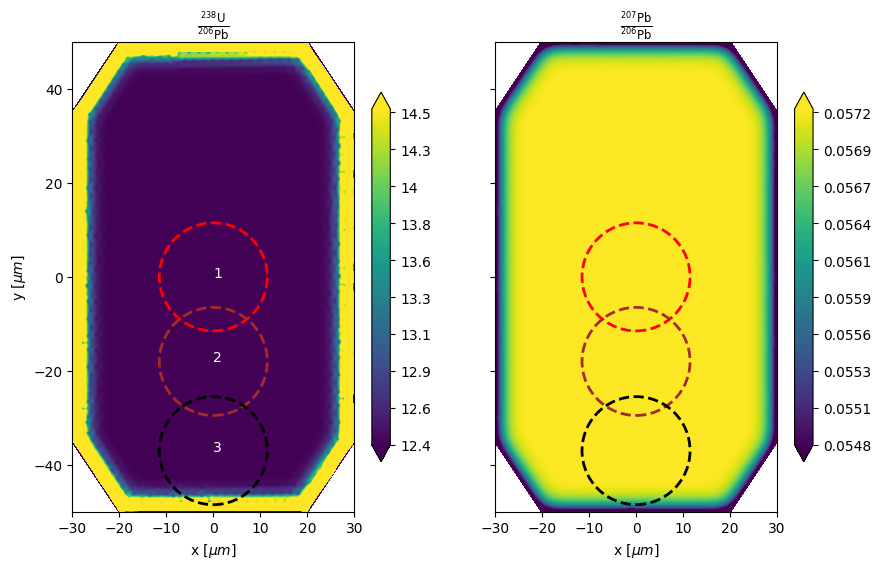

In [35]:
if save_figs:
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, ax = plt.subplots(1,2, figsize=(10, 8), sharey=True)
    
    
    x_coord = U235_Pb207.daughter_mesh_var.coords[:,0]*100
    y_coord = U235_Pb207.daughter_mesh_var.coords[:, 1]*100
    
    
    contour0  = ax[0].tricontourf(x_coord, y_coord, ratio_U23Pb8206[:,0], levels=np.linspace(np.quantile(ratio_U23Pb8206, 0.05), np.quantile(ratio_U23Pb8206, 0.9),101), extend='both')
    contour1  = ax[1].tricontourf(x_coord, y_coord, ratio_Pb207_Pb206[:,0], levels=np.linspace(np.quantile(ratio_Pb207_Pb206, 0.05), np.quantile(ratio_Pb207_Pb206, 1),101), extend='both')

    contour0.set_edgecolors("face")
    contour1.set_edgecolors("face")
    
    plt.colorbar(contour0, ax=ax[0], shrink = 0.6, format='%.3g')
    plt.colorbar(contour1, ax=ax[1], shrink = 0.6, format='%.3g')
    
    
    DIF.utilities.plot_spot_sample([0,0], spot_r.m, ax=ax[0], colour='red')
    DIF.utilities.plot_spot_sample([0,0], spot_r.m, ax=ax[1], colour='red')
    DIF.utilities.plot_spot_sample([0,-18], spot_r.m, ax=ax[0], colour='brown')
    DIF.utilities.plot_spot_sample([0, -18], spot_r.m, ax=ax[1], colour='brown')
    DIF.utilities.plot_spot_sample([0,-37], spot_r.m, ax=ax[0], colour='k')
    DIF.utilities.plot_spot_sample([0, -37], spot_r.m, ax=ax[1], colour='k')

    ax[0].set_title(r'$\frac{^{238}\mathrm{U}}{^{206}\mathrm{Pb}}$')
    ax[1].set_title(r'$\frac{^{207}\mathrm{Pb}}{^{206}\mathrm{Pb}}$')
    
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    
    ax[0].set_ylabel(r'y [$\mu m$]')
    ax[0].set_xlabel(r'x [$\mu m$]')
    ax[1].set_xlabel(r'x [$\mu m$]')

    ax[0].text(0,0, '1', c='w')
    ax[0].text(0,-18, '2', c='w')
    ax[0].text(0,-37, '3', c='w')
    
    plt.savefig(f'{outputPath}/zircon_results+sample_spots.pdf', bbox_inches='tight')




-----
#### Here we plot the Terra-wasserburg plot, where we can assess the amount of discordance due to diffusion

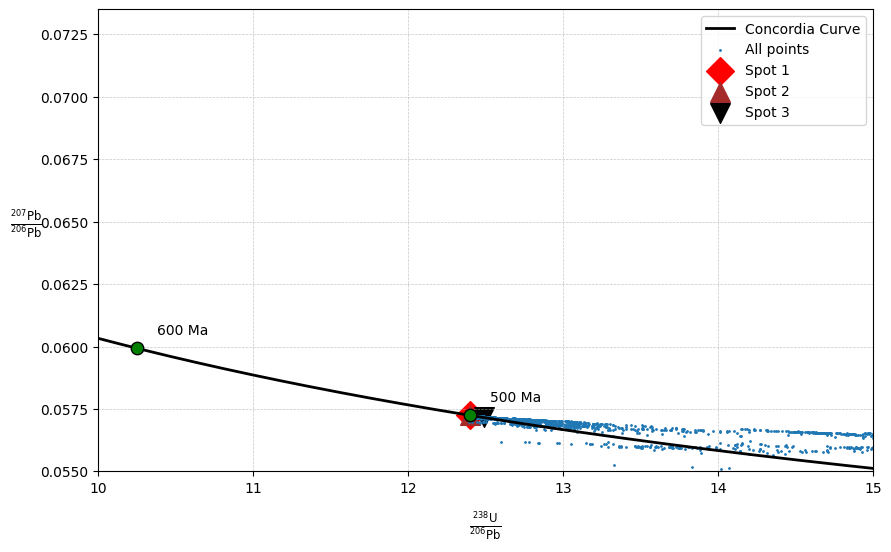

In [ ]:
if save_figs:
    fig, ax = plt.subplots(figsize=(10,6))
    DIF.utilities.plot_terra_wasserburg_plot(start_time=1200e6, end_time=100e6, marker_spacing=100e6, ax=ax)
    
    # ax.scatter(ratio_U23Pb8206[~np.isnan(ratio_U23Pb8206)], ratio_Pb207_Pb206[~np.isnan(ratio_Pb207_Pb206)], zorder=0, s=1, label='All points')
    
    ax.set_xlim(10, 15)
    ax.set_ylim(0.055, 0.0735)
    
    ax.scatter(np.average(sample_spot0[1]), np.average(sample_spot0[0]), marker='D', s=200, c='red', zorder=-1, label='Spot 1')
    ax.scatter(np.average(sample_spot1[1]), np.average(sample_spot1[0]), marker='^', s=200, c='brown', zorder=-1, label='Spot 2') 
    ax.scatter(np.average(sample_spot2[1]), np.average(sample_spot2[0]), marker='v', s=200, c='k', zorder=-1, label='Spot 3') 


    ax.set_ylabel(r'$\frac{^{207}\mathrm{Pb}}{^{206}\mathrm{Pb}}$', rotation=0, labelpad=10)
    ax.set_xlabel(r'$\frac{^{238}\mathrm{U}}{^{206}\mathrm{Pb}}$', rotation=0, labelpad=10)
    
    ax.legend(fontsize=10, loc="best", frameon=True)

    plt.savefig(f'{outputPath}/concordia_plot+spot_data.pdf', bbox_inches='tight')

    

----
Finally, we save the timing results and some stats from the model

In [37]:
time_end = time.time()

total_time = time_end - time_start

In [38]:
if uw.mpi.rank == 0:
    import pandas as pd

    # --- File 1: Data in columns (standard CSV) ---
    timing_data = timing.get_data()
    rows = []
    for (location, idx), (count, time) in timing_data.items():
        rows.append({
            'Location': location,
            'Index': idx,
            'Count': count,
            'Time': time,
            'Average': time/count,
        })
    df = pd.DataFrame(rows)
    df.sort_values(by='Average', inplace=True, ascending=False)
    df.to_csv(f'{outputPath}/Diffusion_results_columns.csv', index=False)

    # --- File 2: Data in rows (single row, best for summary) ---
    summary = {
        'U_degree': U_degree,
        'n_unknowns': U238_Pb206.daughter_mesh_var.coords.shape[0],
        'MinRadius': U238_Pb206.mesh.get_min_radius(),
        # 'Pb_L2_norm': Pb_l2_norm,
        # 'U_L2_norm' : U_l2_norm,
        'CFL_fac' : CFL_fac,
        'TotalTime': total_time,
        'NumProcessors': uw.mpi.size,
    }
    # Save as a single row (header + values)
    with open(f'{outputPath}/Diffusion_results_rows.csv', 'w') as f:
        f.write(','.join(summary.keys()) + '\n')
        f.write(','.join(str(v) for v in summary.values()) + '\n')